In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix, csr_matrix, vstack
import copy
import os
import helper
from wl import *
from joblib import Parallel, delayed
from time import time
import matplotlib.pyplot as plt
from glob import glob
import math
import pandas as pd
import collections
import sklearn
from sklearn import linear_model
import psutil
import pickle
import functools
from matplotlib import cm
from IPython.display import display
from sklearn import utils

In [1]:
GRAPH_DIR = 'data/graphs/ng-20-single'
GRAPH_DIR = 'data/graphs/ng20-co-occurrence-preprocessed'
ORIGINAL_DOCUMENTS_DIR = 'extract-concept-graphs/code/data/ng20__single/train'

In [2]:
def flatten(l, as_set = False):
    return functools.reduce(lambda acc, x: acc | set(x) if as_set else acc + list(x), l, set() if as_set else list())

## Retrieve graphs from Tobias' concept-graph extraction library

In [6]:
def get_graphs(directory, ext = 'gml', undirected = False, verbose = False, limit_elements = -1):
    graphs = {}
    empty_graphs = []
    files = sorted(glob(directory + '/*' + ext))
    graph_ids = []
    file_list = list(enumerate(files))
    if limit_elements != -1:
        file_list = sklearn.utils.shuffle(file_list)[:limit_elements]
    for idx, graph_file in helper.log_progress(file_list, every = 100):
        topic_and_id = graph_file.split('/')[-1].replace('.gml', '')
        
        topic = topic_and_id.split('_')[0]
        if topic not in graphs:
            graphs[topic] = []
        with open(graph_file) as f:
            graph = f.read().split('\n')
        for idx, line in enumerate(graph):
            if line.startswith('label'):
                next_line = graph[idx + 1]
                label = next_line.replace('name', 'label')
                graph[idx] = label
        try:
            graph = nx.parse_gml(graph)
            if undirected:
                graph = graph.to_undirected()
            #graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic].append(graph)
                graph_ids.append(topic_and_id)
            else:
                empty_graphs.append(topic_and_id)
                if verbose: print("Found empty graph: {}".format(graph_file))
        except nx.NetworkXError as e:
            if verbose: print('Exception ({}): {}'.format(graph_file, e))
    if verbose: print('Found empty graphs: {}'.format(len(empty_graphs)))
    return graphs, empty_graphs, graph_ids

graphs_per_topic, empty_graphs, graph_ids = get_graphs(GRAPH_DIR, undirected = False, verbose = False, limit_elements = -1)

## Retrieve original documents

In [13]:
def get_original_documents(DIR, ext = '/*/*.txt', whitelist = (), verbose = False):
    topics = collections.defaultdict(lambda: [])
    for file in helper.log_progress(list(sorted(glob(DIR + ext))), every = 100):
        topic_and_id = file.split('/')[-2]
        topic = topic_and_id.split('_')[0]
        if topic_and_id not in whitelist:
            if verbose: print('Ignoring: {} (not in whitelist)'.format(topic_and_id))
            continue
        with open(file) as f:
            topics[topic].append(f.read())
    return topics
docs_per_topic = get_original_documents(ORIGINAL_DOCUMENTS_DIR, whitelist = graph_ids)

Widget Javascript not detected.  It may not be installed or enabled properly.


## Statistics about the graphs

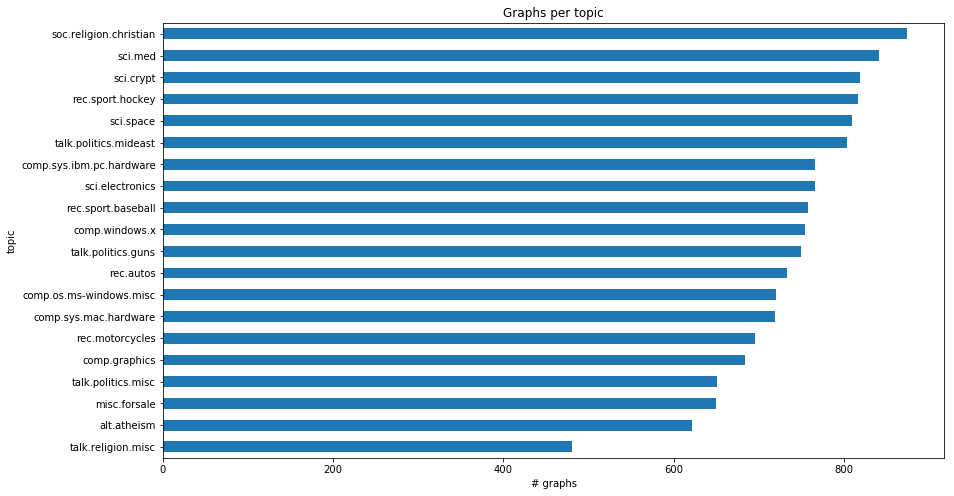

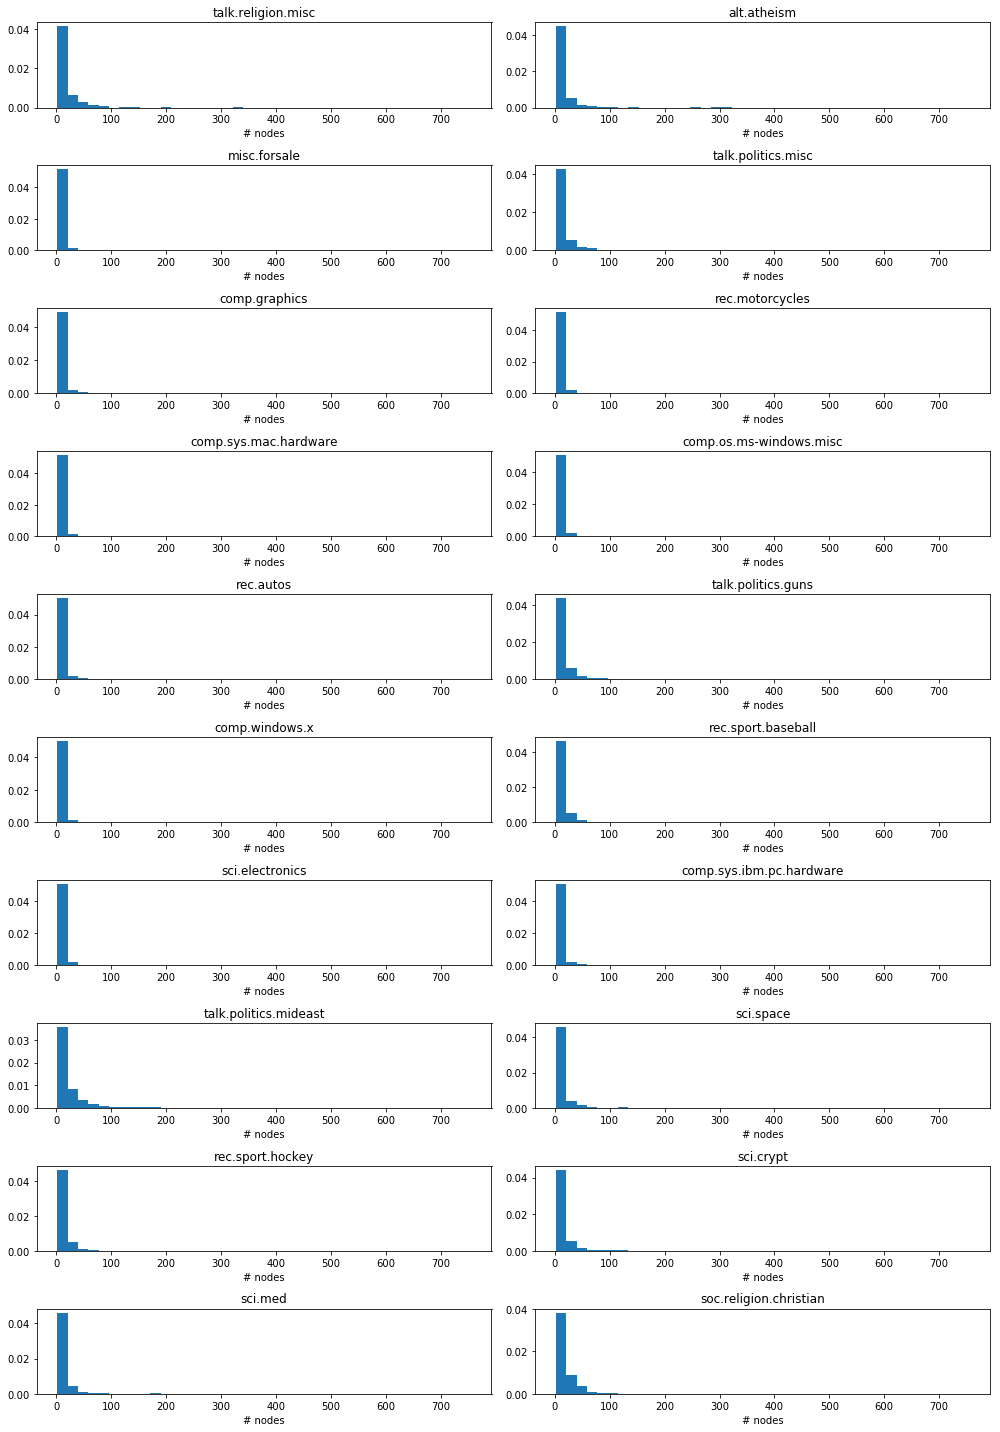

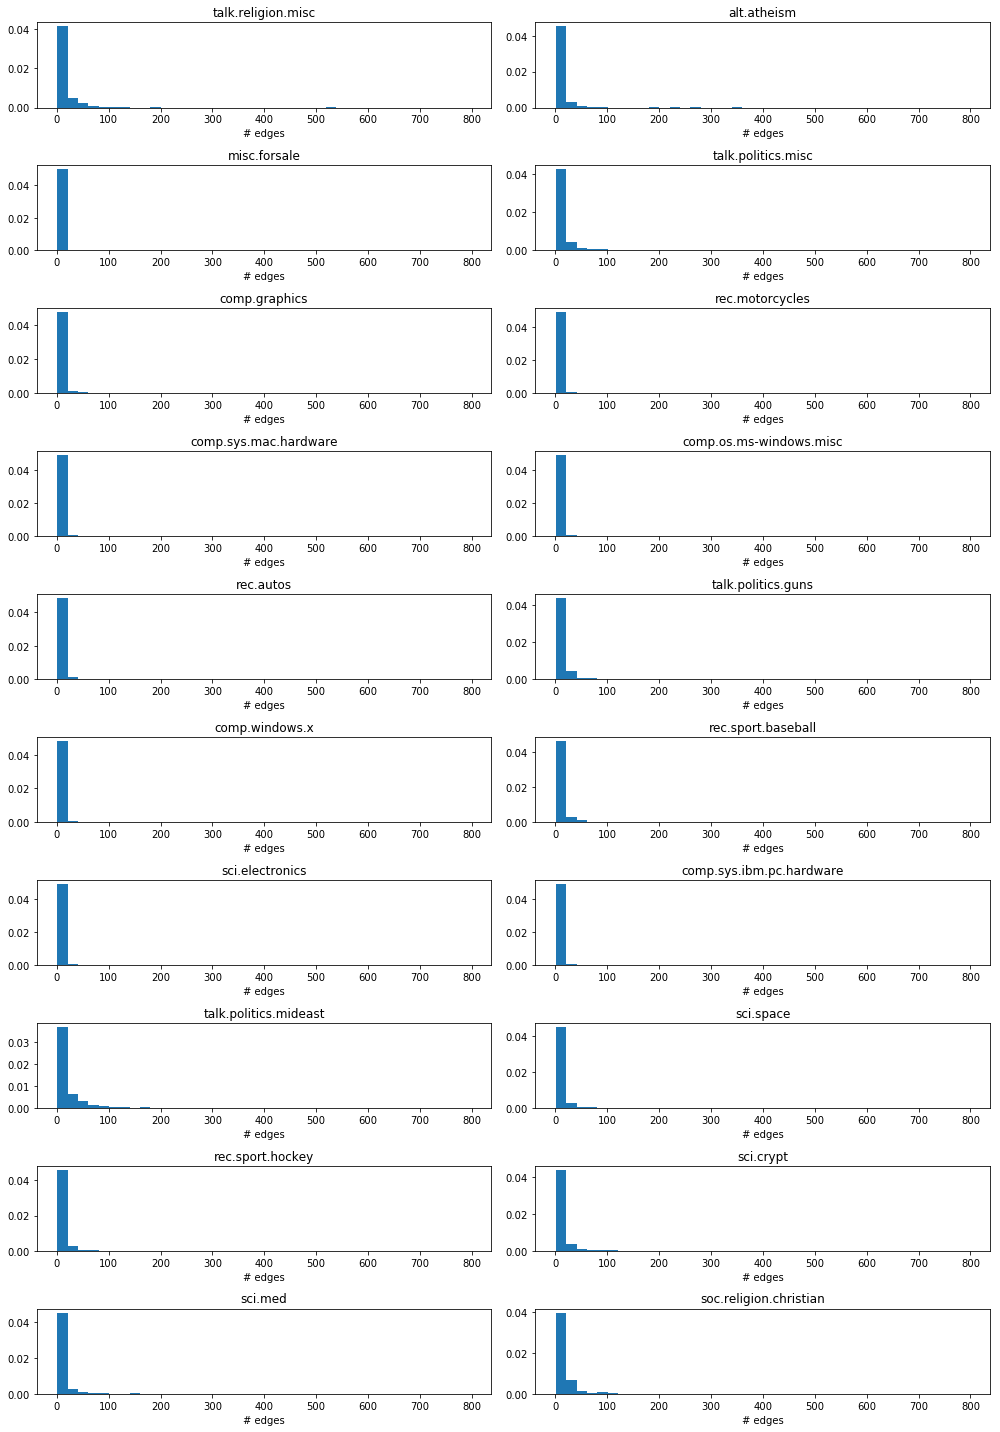

In [7]:
df_graphs_per_topic = pd.DataFrame([(topic, len(graphs), [len(x.nodes()) for x in graphs], [len(x.edges()) for x in graphs]) for topic, graphs in graphs_per_topic.items()], columns = ['topic', 'num_graphs', 'num_nodes', 'num_edges']).set_index(['topic']).sort_values(by = 'num_graphs')
ax = df_graphs_per_topic.plot.barh(title = 'Graphs per topic', legend = False, figsize = (14, 8))
ax.set_xlabel('# graphs')
plt.show()

def get_range_of(df, column):
    return df[column].apply(lambda x: min(x)).min(), df[column].apply(lambda x: max(x)).max()

nodes_range = get_range_of(df_graphs_per_topic, 'num_nodes')
edges_range = get_range_of(df_graphs_per_topic, 'num_edges')


ncols, nrows = (2, 10)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
fig_, axes_ = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
for idx, (topic, (num_graphs, num_nodes, num_edges)) in enumerate(df_graphs_per_topic.iterrows()):
    row = int(idx / ncols)
    col = idx % ncols
    ax = axes[row][col]
    ax_ = axes_[row][col]
    
    # 
    ax.set_title("{}".format(topic))
    ax.set_xlabel('# nodes')
    ax.hist(num_nodes, bins=40, normed = True, range = nodes_range)
    
    #
    ax_.set_title("{}".format(topic))
    ax_.set_xlabel('# edges')
    ax_.hist(num_edges, bins=40, normed = True, range = edges_range)
fig.tight_layout()
fig_.tight_layout()
plt.show()

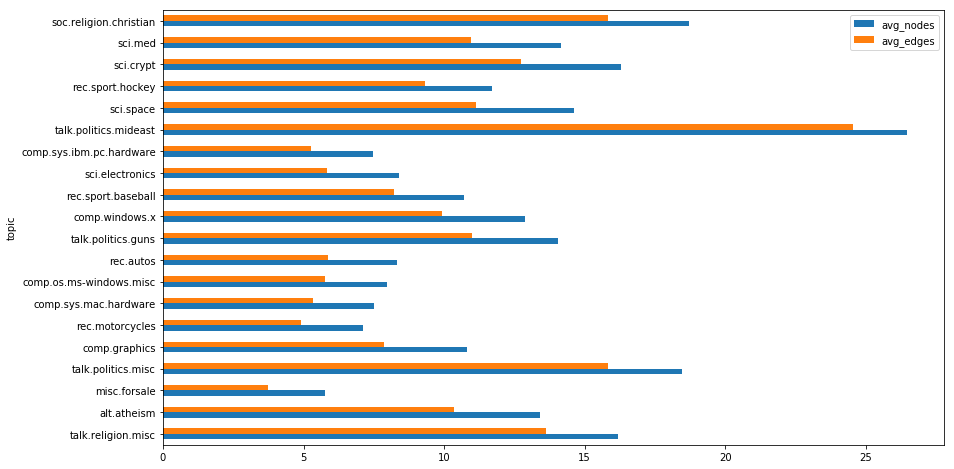

In [8]:
df_graphs_per_topic['avg_nodes'] = df_graphs_per_topic.num_nodes.apply(lambda x: np.mean(x))
df_graphs_per_topic['avg_edges'] = df_graphs_per_topic.num_edges.apply(lambda x: np.mean(x))
df_graphs_per_topic.plot(kind = 'barh', y = ['avg_nodes', 'avg_edges'], figsize = (14, 8))
plt.show()

## Filter categories

In [8]:
REMOVE_CATEGORIES = ['misc.forsale', 'comp.graphics']
REMOVE_CATEGORIES = []
graphs = graphs_per_topic.copy()
#docs = docs_per_topic.copy()
if len(REMOVE_CATEGORIES):
    for cat in REMOVE_CATEGORIES:
        del graphs[cat]
        #del docs[cat]

In [11]:
all_graphs = flatten(graphs.values())
#all_docs = flatten(docs.values())

In [12]:
all_nodes = set()
for g in all_graphs:
    all_nodes |= set(g.nodes())

In [12]:
print('#docs:\t\t{}\n#graphs:\t{}'.format(len(all_docs), len(all_graphs)))
print('Unique tokens found: {}'.format(len(all_nodes)))
assert len(all_docs) == len(all_graphs)

#docs:		0
#graphs:	14710
Unique tokens found: 125397


AssertionError: 

## Create train/test split

In [13]:
def get_train_test_split(topic_graphs, train_split_ratio = 0.8):
    train = []
    test = []
    num_elements = {}
    for topic, graphs in topic_graphs.items():
        num_elements_train = int(len(graphs) * train_split_ratio)
        train += [(topic, x) for x in graphs[:num_elements_train]]
        test += [(topic, x) for x in graphs[num_elements_train:]]
    return train, test

train, test = get_train_test_split(graphs)

In [ ]:
print('#graphs\n\ttrain:\t{}\n\ttest:\t{}'.format(len(train), len(test)))

In [14]:
def plot_label_distribution(Y):
    a = pd.DataFrame(Y, columns = ['label'])
    return a.label.value_counts().to_frame().sort_values(by = 'label')

show(plot_label_distribution([topic for topic, x in train]))
show(plot_label_distribution([topic for topic, x in test]))

NameError: name 'show' is not defined

In [15]:
H = 2

## Calculate phi and gram-matrix of WL kernel for training instances

In [16]:
adjs = []
nodes = []
for topic, graph in train:
    sorted_nodes = sorted(graph.nodes())
    adjs.append(nx.adjacency_matrix(graph, nodelist = sorted_nodes))
    nodes.append(sorted_nodes)
    
print('Calculating WL_train: start', psutil.virtual_memory())
K_train, phi_list_train, label_lookup_train, label_counters_train = WL_compute(adjs, nodes, H, all_nodes = all_nodes, DEBUG = True, compute_k = False)
print('Calculating WL_train: end', psutil.virtual_memory())

Calculating WL_train: start svmem(total=8589934592, available=3962040320, percent=53.9, used=4738531328, free=2847858688, active=2147311616, inactive=1114181632, wired=1477038080)
Number of original labels 60819
K original is computed
Iteration 0: phi is computed
	Graph          0/14191
	Graph       1000/14191
	Graph       2000/14191
	Graph       3000/14191
	Graph       4000/14191
	Graph       5000/14191
	Graph       6000/14191
	Graph       7000/14191
	Graph       8000/14191
	Graph       9000/14191
	Graph      10000/14191
	Graph      11000/14191
	Graph      12000/14191
	Graph      13000/14191
	Graph      14000/14191
Number of compressed labels 392485
Itaration 0: phi computed
Iteration 1: phi is computed
	Graph          0/14191
	Graph       1000/14191
	Graph       2000/14191
	Graph       3000/14191
	Graph       4000/14191
	Graph       5000/14191
	Graph       6000/14191
	Graph       7000/14191
	Graph       8000/14191
	Graph       9000/14191
	Graph      10000/14191
	Graph      11000/1419

## Train classifier with the phi s of the training instances

In [17]:
clf = sklearn.linear_model.Perceptron(n_iter = 500, verbose = False, n_jobs = -1)
X = phi_list_train[-1].T
Y = [topic for topic, graphs in train]
clf.fit(X, Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=500, n_jobs=-1, penalty=None, random_state=0, shuffle=True,
      verbose=False, warm_start=False)

## Get predictions for test instances

### Calculate test phi s

In [18]:
%%time
def get_prediction(topic, graph):
    return compute_phi(graph, phi_list_train[0].shape, label_lookup_train, label_counters_train, h = H)[-1]

USED_SET = test
PARALLEL_PREDICTION_JOBS = 0
t = time()

if PARALLEL_PREDICTION_JOBS > 1:
    phi_test = Parallel(n_jobs=PARALLEL_PREDICTION_JOBS)(delayed(get_prediction)(*d) for d in list(USED_SET))
else:
    phi_test = [get_prediction(*d) for d in USED_SET]

CPU times: user 1min 47s, sys: 8.11 s, total: 1min 55s
Wall time: 1min 55s


In [19]:
nodes_nums = sum([nx.number_of_nodes(graph) for topic, graph in train])
nodes_nums

409856

### Predict test instances

In [20]:
%%time
def calculate_batches(l, fn, num_batches = 10, print_every = 5):
    elements = []
    num_elements_per_batch = math.ceil(len(l) / num_batches)
    print('Starting: #elements: {}, #batches: {}, #elements per Batch: {}'.format(len(l), num_batches, num_elements_per_batch))
    for idx in range(num_batches):
        start = idx * num_elements_per_batch
        end = min(len(l), start + num_elements_per_batch)
        if idx % print_every == 0: print('\tIteration: {:>4}/{}'.format(idx, num_batches))
        if end - start <= 0:
            break
        elements += fn(l[start:end]).tolist()
    return elements
predicted = calculate_batches(phi_test, clf.predict)

Starting: #elements: 3556, #batches: 10, #elements per Batch: 356
	Iteration:    0/10
	Iteration:    5/10
CPU times: user 24.9 s, sys: 20.2 s, total: 45.1 s
Wall time: 33.7 s


### Metrics

In [21]:
Y_real = [topic for topic,graph in USED_SET]
Y_pred = predicted

#### About sparsity of test phi

In [ ]:
df_phi_test_non_zero_elements = pd.DataFrame(list(zip(Y_real, Y_pred, [np.count_nonzero(x) for x in phi_test])), columns = ['real_topic', 'pred_topic', 'num_phi_non_zero'])

In [ ]:
display(df_phi_test_non_zero_elements.groupby(by = 'real_topic').describe())
display(df_phi_test_non_zero_elements.groupby(by = 'pred_topic').describe())

In [ ]:
max_ = 0
vals_over_1 = 0
for i in phi_test:
    vals = i[i > 1]
    if not len(vals): continue
    vals_over_1 += 1
    m = max(vals)
    if m > max_:
        max_ = m
        print(max_)
print(vals_over_1)

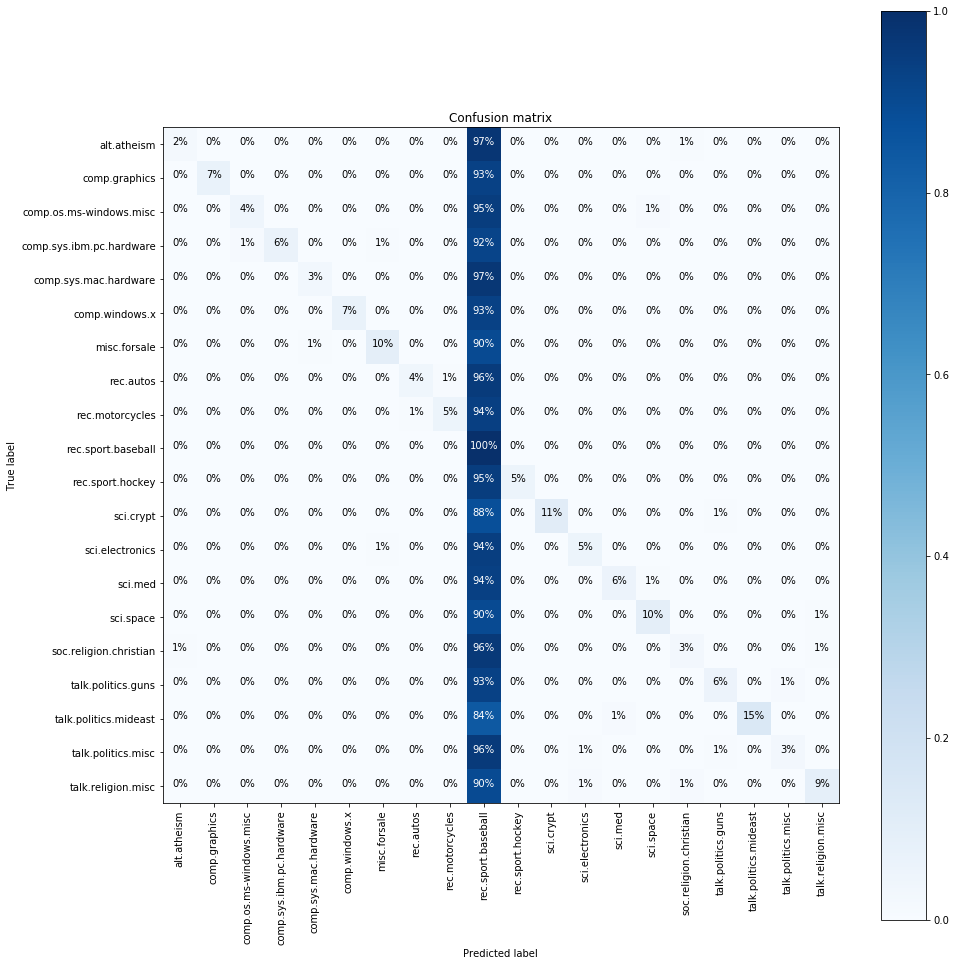

In [22]:
cf_mat = sklearn.metrics.confusion_matrix(Y_real, Y_pred)
fig = plt.figure(figsize=(14, 14))
helper.plot_confusion_matrix(cf_mat, clf.classes_, normalize = True)
plt.show()

In [23]:
sklearn.metrics.f1_score(Y_real, Y_pred, average='macro')

0.11581446540591056

## with open('data/graphs.npy', 'wb') as f:
    pickle.dump({
            'train': train,
            'test': test,
            'K_train': K_train,
            'phi_list_train': phi_list_train,
            'label_lookup_train': label_lookup_train,
            'label_counters_train': label_counters_train
    }, f)